# Optimized Race Line (ORL)

Track-based analysis, iterating over given plots to define an optimized race line.

Ref: [Capstone AWS DeepRacer](https://github.com/dgnzlz/Capstone_AWS_DeepRacer/)
Ref (Original): [cdthompson k1999-race-lines](https://github.com/cdthompson/deepracer-k1999-race-lines/)

In [2]:
import os.path
import copy
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from shapely import LineString, Polygon, Point

## Setup

In [3]:
# Global declarations
TRACKS_DIR = "../resources/tracks"
RACE_LINES_DIR = "../resources/racelines"

TRACK_NAME = "2022_october_pro"

# Track-based parameters; change and recalculate as desired
opt_track_width_reduction_perc: float = 0.80  # as % of default width

In [4]:
# Setup Generics
class TrackDotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)
    
def get_available_tracks(base_dir: str = TRACKS_DIR) -> list:
    available_track_files = glob.glob(f"{base_dir}/**.npy")
    available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
    return available_track_names

In [5]:
# Track Data
def get_track_data_by_arn(base_dir: str = TRACKS_DIR, filename: str = TRACK_NAME):
    with open(f"{base_dir}/tracks.json", "r") as track_json_file:
        for i in json.load(track_json_file):
            lower_arn: str = i.get('TrackArn', '').lower()
            if lower_arn.endswith(filename.lower()):
                return i
    return None

def get_default_waypoints(base_dir: str = TRACKS_DIR, filename: str = TRACK_NAME):
    return np.load(f"{base_dir}/{filename}.npy")

def get_reduced_waypoints(given_points, reduce_by: float = opt_track_width_reduction_perc):
    def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    def x_perc_width(waypoint, perc_width):
        center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
        width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
        
        delta_x = outer_x-inner_x
        delta_y = outer_y-inner_y
    
        inner_x_new = inner_x + delta_x/2 * (1-perc_width)
        outer_x_new = outer_x - delta_x/2 * (1-perc_width)
        inner_y_new = inner_y + delta_y/2 * (1-perc_width)
        outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
        return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]
    reduced_points = [x_perc_width(waypoint, perc_width=reduce_by) for waypoint in given_points]
    reduced_points_array = np.asarray(reduced_points)
    r_inner_border = reduced_points_array[:,2:4]
    r_outer_border = reduced_points_array[:,4:6]
    return r_inner_border, r_outer_border

In [6]:
# For ease of use...
__track_ctx = get_track_data_by_arn(filename=TRACK_NAME)

track = TrackDotDict({
    'name': TRACK_NAME,
    'width': __track_ctx.get('TrackWidth'),
    'length': __track_ctx.get('TrackLength')
})
print(track)

{'name': '2022_october_pro', 'width': 1.07, 'length': 62.08}


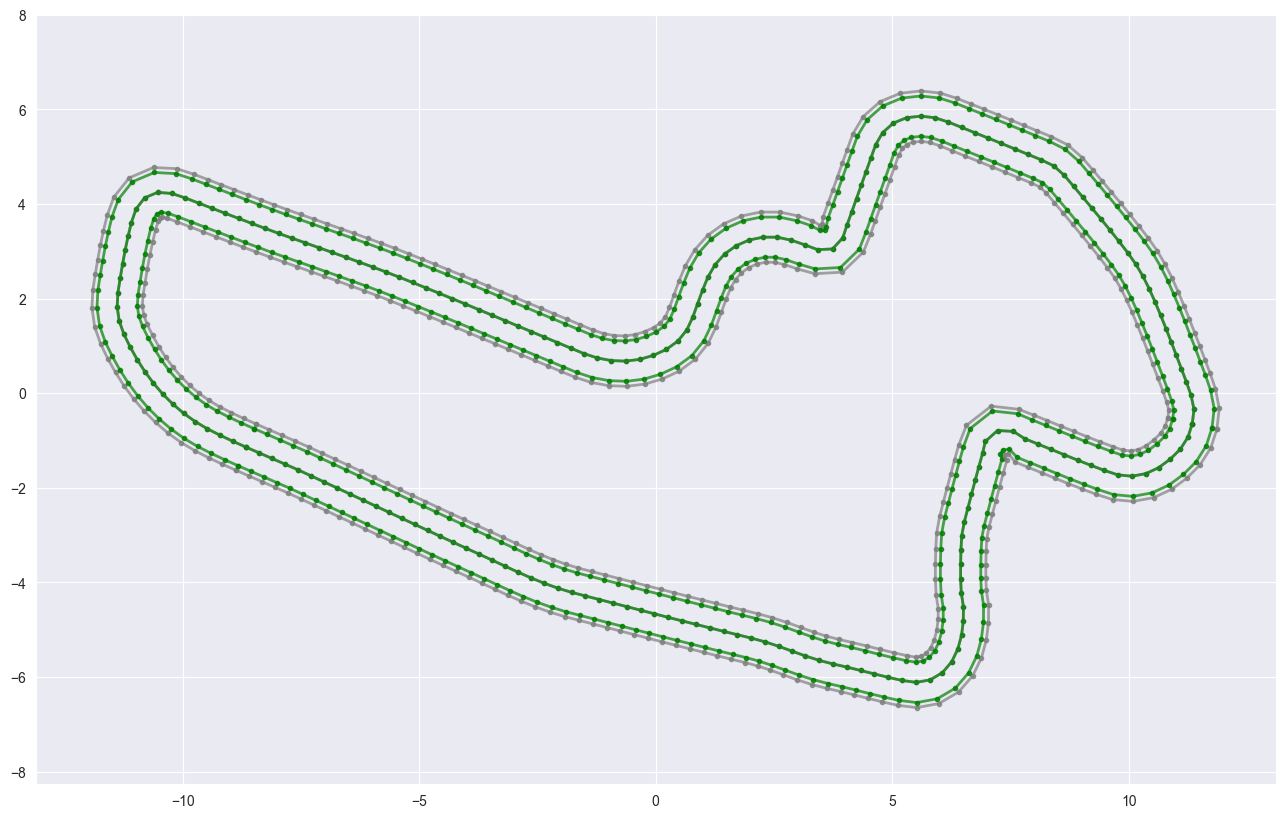

In [7]:
# Load and transform waypoints

def plot_track(ax, points, inner_points, outer_points, theme, orl=False):
    def plot_coords(ax, ob, theme=theme):
        x, y = ob.xy
        ax.plot(x, y, '.', alpha=0.8, color=theme, linewidth=1, zorder=1)

    def plot_line(ax, ob, theme=theme):
        x, y = ob.xy
        ax.plot(x, y, alpha=0.7, color=theme, linewidth=2, solid_capstyle='round', zorder=2)

    line = LineString(points)
    plot_coords(ax, line, theme if not orl else 'red')
    plot_line(ax, line, theme if not orl else 'red')

    line = LineString(inner_points)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_points)
    plot_coords(ax, line)
    plot_line(ax, line)

# def-prefix: default values
def_waypoints = get_default_waypoints(base_dir=TRACKS_DIR, filename=TRACK_NAME)
def_center = def_waypoints[:,0:2]
def_inner = def_waypoints[:,2:4]
def_outer = def_waypoints[:,4:6]

# red-prefix: reduced values
red_inner, red_outer = get_reduced_waypoints(given_points=def_waypoints, reduce_by=opt_track_width_reduction_perc)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax, def_center, def_inner, def_outer, 'gray')
plot_track(ax, def_center, red_inner, red_outer, 'green')


# Calculate Optimized Race Line (ORL, orl)

In [8]:
# Number of times to iterate each new race line point; Suggest 3-8 to balance performance and result
XI_ITERATIONS=8 # explicitly called in improve_race_line

# Number of times to scan the entire race track to iterate; Suggest 500 to start, ~1500-2000 standard
LINE_ITERATIONS=1000 # default 1000

## Gen 1 : calculate and normalize vectors for each iteration
- Curvature: with 3 sequential points, compute vectors between them, and normalize them (to avoid division by 0)
- Calculate angle between the vectors, with arccosine (trigonometry)
- Compute curvature based on sine of the angle, and distance between point 1 and point 3

- Improve race line: deep copy the input line, and sets the inner/outer borders as a polygon
- Iteratively, for each point, calculate curvature ( x-1, x, x+1), and adjust to balance curvature between points
- Point shifts within boundaries by interpolation, until diff is minimized or reaches stopping criteria 

In [19]:
def menger_curvature(point1, point2, point3):
    """Calculate the curvature using the Menger curvature formula."""
    vec21 = np.array(point2) - np.array(point1)
    vec23 = np.array(point2) - np.array(point3)
    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    if norm21 == 0 or norm23 == 0:
        return 0

    # Ensure the dot product is within the valid range for arccos
    dot_product = np.dot(vec21, vec23) / (norm21 * norm23)
    dot_product = np.clip(dot_product, -1.0, 1.0)

    theta = np.arccos(dot_product)
    curvature = 2 * np.sin(theta) / np.linalg.norm(np.array(point1) - np.array(point3))

    return curvature

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

def generate_new_race_line(line_iterations=LINE_ITERATIONS, base_line=def_center, inner_boundary=red_inner, outer_boundary=red_outer):
    """
    Establish track constraints and basis for calculating new race lines. Iterate through plot/line values to create an optimized outcome.
    :param line_iterations: # of times to scan and iterate over the entire track
    :param base_line: sliced waypoints; basis for setting the 'outer' boundary in calculations
    :param inner_boundary: sliced points; maximum inner border/boundary in calculation
    :param outer_boundary: sliced points; maximum outer border/boundary in calculation
    :return: array of tuples, optimized race line
    """
    target_line = copy.deepcopy(base_line[:-1])  # slice, rm last item, which is later re-added to complete the loop
    for i in range(line_iterations):
        target_line = improve_race_line(target_line, inner_boundary, outer_boundary)
        if i % 20 == 0: print(f"Iteration {i}/{line_iterations}", end="\r", flush=True)

    optimized_race_line = np.append(target_line, [target_line[0]], axis=0)
    print("Provided : Optimized Race Line Comparison Summary")
    print("These should be the same: ", (base_line.shape, optimized_race_line.shape))
    print(".. Original centerline length: %0.2f" % LineString(def_center).length)
    print(".. New race line length: %0.2f" % LineString(optimized_race_line).length)
    return optimized_race_line


In [ ]:
orl_base = generate_new_race_line()

In [ ]:
orl_2k = generate_new_race_line(line_iterations=2000, base_line=def_center, inner_boundary=red_inner, outer_boundary=red_outer)

In [ ]:
orl_5k = generate_new_race_line(line_iterations=5000, base_line=def_center, inner_boundary=red_inner, outer_boundary=red_outer)

In [ ]:
orl_10k = generate_new_race_line(line_iterations=10000, base_line=def_center, inner_boundary=red_inner, outer_boundary=red_outer)

## Gen 2 : calculate cross product, NP operators
- Changes TLDR: replace use of trig functions and python iterations, with numpy operations

- Curvature: compute with cross-product formula. bypass need to calculate angles and use trig functions

- Improve race line: store calculations instead of re-computing curvature multiple times per iteration
- Eliminate deep copy of points, by using direct assignments
- NP operators reduce python loops

In [20]:
def revised_menger_curvature(point1, point2, point3):
    p1, p2, p3 = np.array(point1), np.array(point2), np.array(point3)
    vec21 = p2 - p1
    vec23 = p2 - p3
    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)
    if norm21 == 0 or norm23 == 0:
        return 0
    # Using cross product instead of angles
    area = np.linalg.norm(np.cross(vec21, vec23))
    dist = np.linalg.norm(p1 - p3)
    return 2 * area / (norm21 * norm23 * dist)


def extend_to_3d(point):
    '''Extend a 2D point to 3D by adding a z-coordinate of 0'''
    return np.array([point[0], point[1], 0])


def revised_improve_race_line_3d(old_line, inner_border, outer_border, max_iterations=100):
    '''Optimize the racing line using gradient descent-like approach, with 3D vectors.'''

    # Start with the center line
    new_line = [extend_to_3d(p) for p in old_line]

    # Convert borders to 3D points
    ls_inner_border = Polygon([extend_to_3d(p)[:2] for p in inner_border])
    ls_outer_border = Polygon([extend_to_3d(p)[:2] for p in outer_border])

    # Cache number of points
    npoints = len(new_line)

    # Iterate through each point on the line
    for i in range(npoints):
        # Get the current point and neighboring points
        xi = new_line[i]
        prev = new_line[(i - 1) % npoints]
        nexxt = new_line[(i + 1) % npoints]
        prevprev = new_line[(i - 2) % npoints]
        nexxtnexxt = new_line[(i + 2) % npoints]

        # Calculate curvature for the current, previous, and next points
        ci = revised_menger_curvature(prev, xi, nexxt)
        c1 = revised_menger_curvature(prevprev, prev, xi)
        c2 = revised_menger_curvature(xi, nexxt, nexxtnexxt)

        # Target curvature is the average of adjacent curvatures
        target_ci = (c1 + c2) / 2

        # Initialize bounds for adjusting the point
        xi_bound1 = xi
        xi_bound2 = (nexxt + prev) / 2.0

        # Iteratively adjust the point to match the target curvature
        for _ in range(max_iterations):
            p_ci = revised_menger_curvature(prev, xi_bound1, nexxt)

            # Break early if the curvature is close enough to the target
            if np.isclose(p_ci, target_ci, atol=1e-6):
                break

            # Adjust point based on the current curvature
            midpoint = (xi_bound1 + xi_bound2) / 2.0
            midpoint_2d = midpoint[:2]
            midpoint_within_track = Point(midpoint_2d).within(ls_inner_border) and Point(midpoint_2d).within(ls_outer_border)

            if p_ci < target_ci:
                # Too flat, shrink the track (move closer to xi_bound1)
                xi_bound2 = midpoint if midpoint_within_track else xi_bound1
            else:
                # Too curved, flatten the track (move closer to xi_bound2)
                xi_bound1 = midpoint if midpoint_within_track else xi_bound2

        # Update the line point with the new optimized position
        new_line[i] = xi_bound1
    # Convert new_line back to 2D (if necessary)
    return [p[:2] for p in new_line]


def revised_generate_new_race_line(line_iterations=LINE_ITERATIONS, base_line=def_center, inner_boundary=red_inner, outer_boundary=red_outer):
    """
    Establish track constraints and basis for calculating new race lines. Iterate through plot/line values to create an optimized outcome.
    :param line_iterations: # of times to scan and iterate over the entire track
    :param base_line: sliced waypoints; basis for setting the 'outer' boundary in calculations
    :param inner_boundary: sliced points; maximum inner border/boundary in calculation
    :param outer_boundary: sliced points; maximum outer border/boundary in calculation
    :return: array of tuples, optimized race line
    """
    target_line = copy.deepcopy(base_line[:-1])  # slice, rm last item, which is later re-added to complete the loop
    for i in range(line_iterations):
        target_line = revised_improve_race_line_3d(target_line, inner_boundary, outer_boundary, line_iterations)
        if i % 20 == 0: print(f"Iteration {i}/{line_iterations}", end="\r", flush=True)

    optimized_race_line = np.append(target_line, [target_line[0]], axis=0)
    print("Provided : Optimized Race Line Comparison Summary")
    print("These should be the same: ", (base_line.shape, optimized_race_line.shape))
    print(".. Original centerline length: %0.2f" % LineString(def_center).length)
    print(".. New race line length: %0.2f" % LineString(optimized_race_line).length)
    return optimized_race_line

In [21]:
def calculate_race_line_length(race_line):
    '''
    Calculate the total length of a race line.

    Parameters:
        race_line: List of points representing the race line.

    Returns:
        total_length: The total length of the race line.
    '''
    total_length = 0
    for i in range(1, len(race_line)):
        total_length += np.linalg.norm(np.array(race_line[i]) - np.array(race_line[i-1]))
    return total_length


def iterative_race_line_optimization_with_convergence(initial_line, inner_border, outer_border, max_iterations=10, tolerance=1e-4):
    '''
    Iteratively refine the race line until convergence or maximum iterations are reached.
    
    Parameters:
        initial_line: List of points representing the initial race line.
        inner_border: List of points representing the inner border of the track.
        outer_border: List of points representing the outer border of the track.
        max_iterations: Maximum number of iterations to refine the race line.
        tolerance: Convergence tolerance. Stop iterating if change between iterations is below this value.
    
    Returns:
        optimized_line: The optimized race line after all iterations or convergence.
    '''
    current_line = initial_line
    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}", end="\r", flush=True)
        new_line = revised_improve_race_line_3d(current_line, inner_border, outer_border)

        # Calculate the total change between iterations (sum of point distances)
        total_change = sum(np.linalg.norm(np.array(new_line[i]) - np.array(current_line[i])) for i in range(len(current_line)))

        # Check for convergence
        if total_change < tolerance:
            print(f"Converged after {iteration + 1} iterations with total change {total_change:.6f}.")
            break

        current_line = new_line
        
    # output summary
    original_length = calculate_race_line_length(initial_line)
    optimized_length = calculate_race_line_length(current_line)
    
    print(f"Original Race Line Length: {original_length}")
    print(f"Optimized Race Line Length: {optimized_length}")
    print(f"Length Difference: {optimized_length - original_length}")
    print(f"Percentage Change: {(optimized_length - original_length) / original_length * 100:.2f}%")
    return current_line


Original Race Line Length: 62.076141719704985
Optimized Race Line Length: 57.11844733608044
Length Difference: -4.957694383624542
Percentage Change: -7.99%


In [23]:
r_orl = iterative_race_line_optimization_with_convergence(def_center, red_inner, red_outer, max_iterations=10)

In [ ]:
r_orl_1k = iterative_race_line_optimization_with_convergence(def_center, red_inner, red_outer, max_iterations=1000)

In [ ]:
r_orl_2k = iterative_race_line_optimization_with_convergence(def_center, red_inner, red_outer, max_iterations=2000)

In [ ]:
r_orl_5k = iterative_race_line_optimization_with_convergence(def_center, red_inner, red_outer, max_iterations=5000)

In [ ]:
r_orl_10k = iterative_race_line_optimization_with_convergence(def_center, red_inner, red_outer, max_iterations=10000)

## Plotting

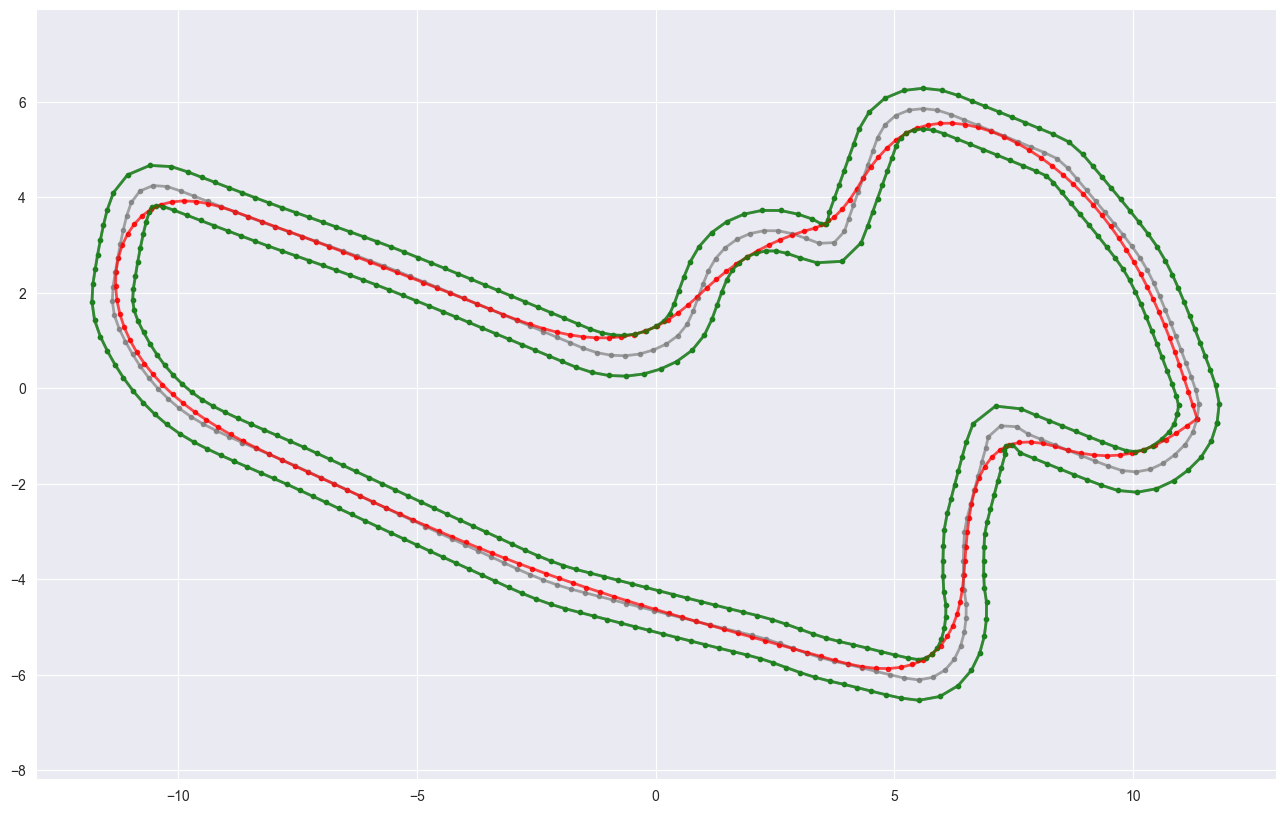

In [14]:
# Plot optimized race line
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax, def_center, red_inner, red_outer, 'gray')
plot_track(ax, orl_2k, red_inner, red_outer, 'green', True)

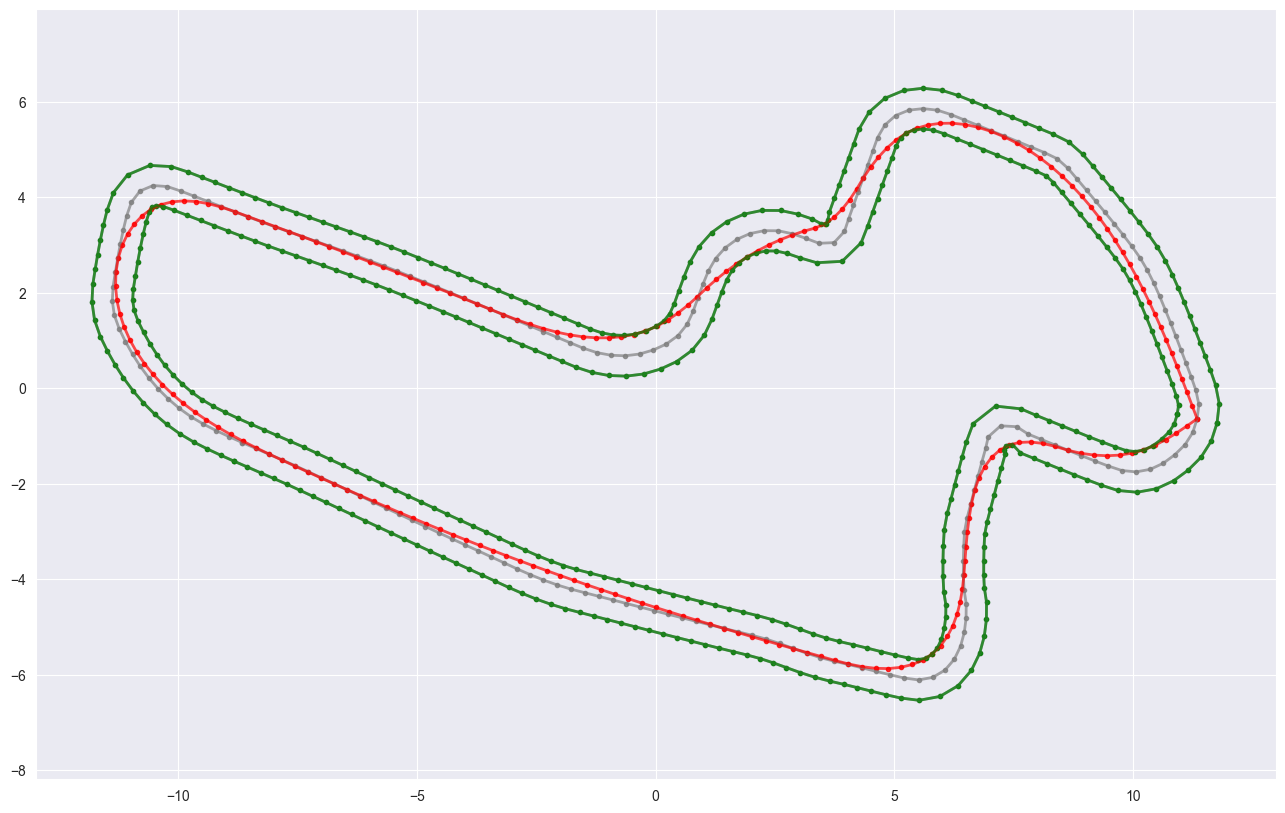

In [13]:
 # Plot optimized race line
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax, def_center, red_inner, red_outer, 'gray')
plot_track(ax, orl_10k, red_inner, red_outer, 'green', True)

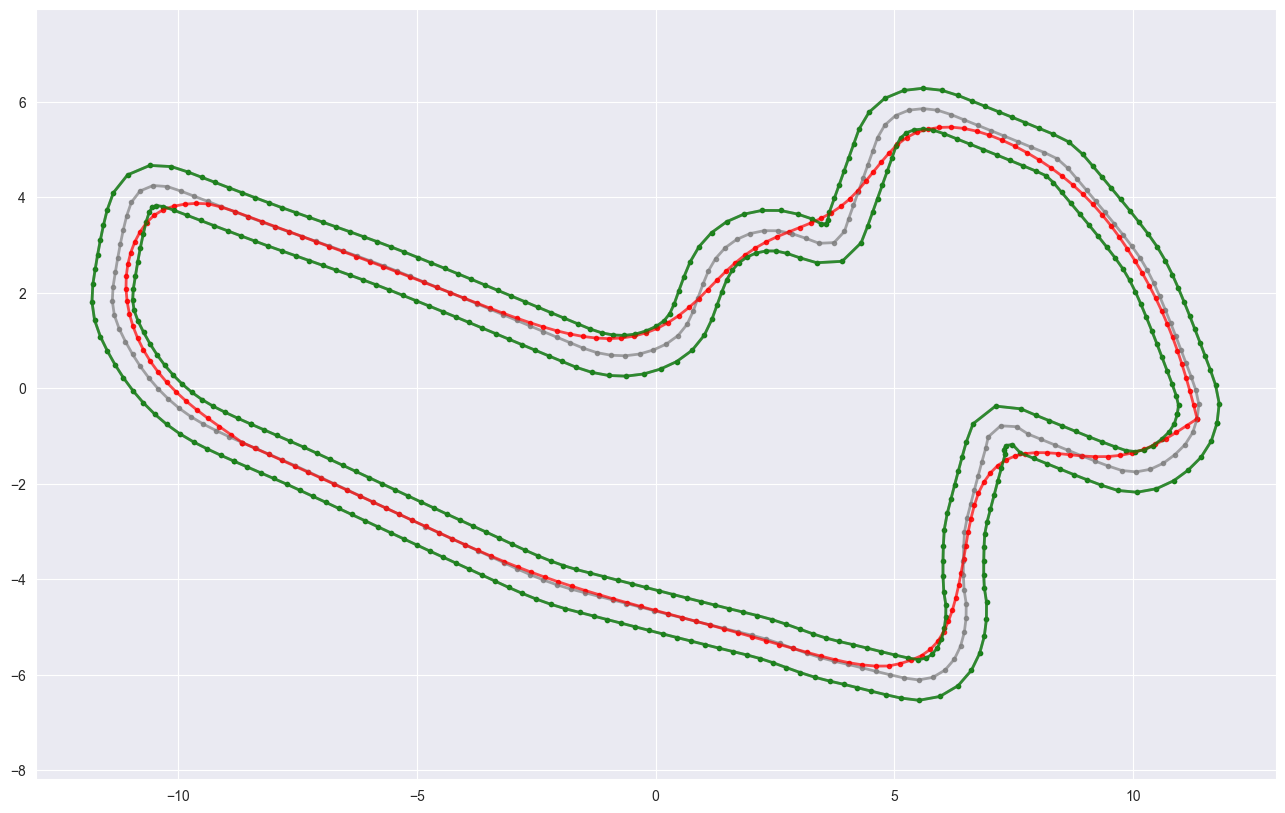

In [13]:

# Plot optimized race line
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax, def_center, red_inner, red_outer, 'gray')
plot_track(ax, r_orl, red_inner, red_outer, 'green', True)